# Single Image PSF Ellipticity 

A notebook to work to understand OSS-REQ-0233,
OSS (Observing System Specifications) https://docushare.lsst.org/docushare/dsweb/Get/LSE-30

## Definitions

**Specification**: The Point spread function ellipticity of bright isolated unresolved sources in images from a
single r-band or i-band visit shall have the properties specified in the table imageEllipticity below.
**Discussion**: These specifications apply to single isolated unresolved sources as delivered to and recorded
by the LSST imaging system.

| Description | Value   | Unit   | Name   |
|------|------|------|------|
|The maximum PSF raw ellipticity limit.  | 0.07 | unitless | SE2 |
|The maximum residual ellipticity correlation amplitude over 1 arcmin scales.  | 2.0e-4 | unitless | SE3 |
|The maximum median raw PSF ellipticity over the full field of view in a single 15 second exposure for bright isolated nonsaturated stars.  | 0.04| unitless | SE1 |
|The fraction of PSF ellipticity measurements allowed to exceed the ellipticity outlier limit for bright isolated non-saturated stars.  | 5 | percent | EF1|
|The maximum median residual ellipticity amplitude outlier limit on scales between 1 and 5 arcmin.  | 1.0e-6 | unitless | SE6 |
|The maximum residual ellipticity correlation amplitude over 5 arcmin scales.| 5.0e-7 | unitless | SE4 |
|The maximum median residual ellipticity amplitude outlier limit on scales less than or equal to 1 arcmin.| 4.0e-4 | unitless | SE5 |
|Fraction of allowed PSF measurements of isolated bright stars to exceed the ellipticity residual correlation amplitude outlier limit.| 10| percent | EF2 |

### PSF Ellipticity

**IMPORTANT:** Two conventions are commonly used in weak gravitational lensing to define ellipticity. The LSST Stack uses the 
"distortion" convention as oppose to the "shear" convention. See https://en.wikipedia.org/wiki/Gravitational_lensing_formalism#Measures_of_ellipticity for both definitions.

The Science Requirements Document (https://docushare.lsst.org/docushare/dsweb/Get/LPM-17) uses the distortion convention.

Adaptive second moments:

$Q = \begin{bmatrix}
    I_{xx} & I_{xy} \\
    I_{xy} & I_{yy}
  \end{bmatrix}$

In case we need the size:
The trace radius is defined as $\rm{Tr}(Q) = \sqrt{\frac{I_{xx} + I_{yy}}{2}}$ and determinant radius is defined as $\rm{Det(Q)} = (I_{xx} I_{yy} - I_{xy}I_{xy})^\frac{1}{4}$

Formalism ellipticities in the distortion convention:

$e_1 = \frac{I_{xx} - I_{yy}}{I_{xx} + I_{yy}}$

$e_2 = \frac{2 I_{xy}}{I_{xx} + I_{yy}}$

$\tan(2 \theta) = \frac{2 I_{xy}}{I_{xx} - I_{yy}} $

$e = \sqrt{e_1^2 + e_2^2}$

###  Bright isolated unresolved sources

In [6]:
#Insert - what exactly is the definition of this? Not in SRD.

## Loading Data

Using run 1.1p as an example.

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
import GCRCatalogs
from GCR import GCRQuery
# Load the coadd catalog
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

In [16]:
#Will need to adjust these cuts.

filters=[
         GCRQuery('extendedness == 0'),
         GCRQuery('clean'), 
         GCRQuery('blendedness < 10**(-0.375)'),
        ~GCRQuery('I_flag'),
         GCRQuery('i_SNR > 21')
]

In [17]:
# Here is a template to fill for g1
e1_modif = lambda ixx,iyy,ixy: (ixx-iyy)/(ixx+iyy)
e2_modif = lambda ixx,iyy,ixy:  2.*ixy/(ixx+iyy)
sigma_modif = lambda ixx,iyy,ixy: (ixx*iyy - ixy**2)**0.25
e1_err = lambda e1: .1*e1
e2_err = lambda e2: .1*e2
e_modif = lambda e1,e2: np.sqrt(e1**2+e2**2)

In [11]:
catalog.add_derived_quantity('e1', e1_modif, 'Ixx', 'Iyy', 'Ixy')
catalog.add_derived_quantity('e2', e2_modif, 'Ixx', 'Iyy', 'Ixy')
catalog.add_derived_quantity('sigma', sigma_modif, 'Ixx', 'Iyy', 'Ixy')

In [13]:
catalog.add_derived_quantity('psf_e1', e1_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')
catalog.add_derived_quantity('psf_e2', e2_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')
catalog.add_derived_quantity('psf_sigma', sigma_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')

In [14]:
catalog.add_derived_quantity('e1_err', e1_err, 'e1')
catalog.add_derived_quantity('e2_err', e2_err, 'e2')

In [25]:
#Todo, add error on e
catalog.add_derived_quantity('e', e_modif, 'e1','e2')

In [58]:
#Todo, add error on psf_e
catalog.add_derived_quantity('psf_e', e_modif, 'psf_e1','psf_e2')

In [59]:
quantities = ['ra', 'dec', 
              'mag_i', 'i_SNR', 'psf_fwhm_i',
              'e1', 'e2', 'sigma',
              'psf_e1', 'psf_e2', 'psf_sigma','IxxPSF','IyyPSF','Ixx','Iyy','x','y','e1_err','e2_err','e','psf_e']

# Would be hidden
data = catalog.get_quantities(quantities, 
                              native_filters=[(lambda x: x==4850, 'tract')],
                              filters=filters)

In [60]:
# Make data a pandas dataframe

data = pd.DataFrame(data)

## Checking Requirement Table 

### Maximum PSF raw ellipticity limit.

0.07 (unitless)

0.04 median

Additionally,

The fraction of PSF ellipticity measurements allowed to exceed the ellipticity outlier limit for bright isolated non-saturated stars is 5%.

In [61]:
data['psf_e'].describe()

count    27393.000000
mean         0.023327
std          0.013122
min          0.000220
25%          0.013888
50%          0.022354
75%          0.030624
max          0.150354
Name: psf_e, dtype: float64

In [91]:
print('The percentage of objects above the limit is',(len(data['psf_e'][data['psf_e']>0.07])/len(data['psf_e']))*100)

The percentage of objects above the limit is 0.6826561530317964


In [94]:
print('The median is', np.median(data['psf_e']), 'this is below the requirement of 0.04.')

The median is 0.0223537097918 this is below the requirement of 0.04.


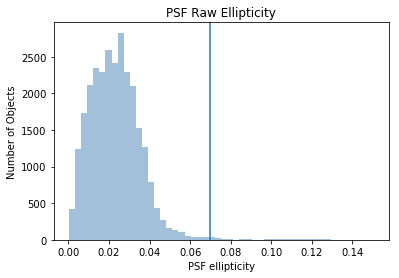

In [90]:
plt.hist(data['psf_e'],bins=50,alpha=0.5,
                histtype='stepfilled', color='steelblue',
                edgecolor=None)
plt.xlabel('PSF ellipticity')
plt.axvline(x=0.07)
plt.ylabel('Number of Objects')
plt.title('PSF Raw Ellipticity')

### The maximum residual ellipticity correlation. amplitude over 1 arcmin scales.

Amplitude:
Over 1 arcmin scale: 2.0e-4
Over 5 arcmin sclae: 5.0e-7

In [66]:
import treecorr
import astropy.units as u

In [67]:
#Plot the residual ellipticity correlation 

nbins=20
min_sep=0.25
max_sep=20
sep_units='arcmin'
verbose=False

catTree = treecorr.Catalog(ra=data['ra'], dec=data['dec'], 
                           g1=data['e1']-data['psf_e1'], g2=data['e2']-data['psf_e2'],
                           dec_units='radian', ra_units='radian')
gg = treecorr.GGCorrelation(nbins=nbins, min_sep=min_sep, max_sep=max_sep,
                            sep_units=sep_units,
                            verbose=verbose)
gg.process(catTree)
r = np.exp(gg.meanlogr) * u.arcmin
xip = gg.xip * u.Unit('')
xip_err = np.sqrt(gg.varxi) * u.Unit('')

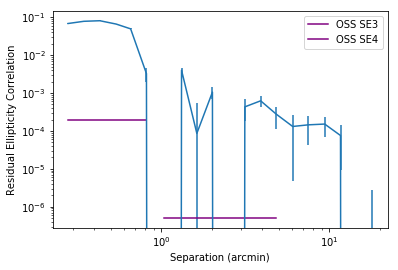

In [92]:
plt.figure()
plt.xscale('log')
plt.yscale('log')
#plt.plot(r.value,list(np.ones(len(xip[r.value<=5]))*.00002)+list(np.ones(len(xip[r.value>5]))*.00000001),label='TE1')
plt.plot(r.value[r.value<=1],np.ones(len(xip[r.value<=1]))*2.0e-4,label='OSS SE3',color='purple')
lim1 = r.value<5
lim2 = r.value>1
lim = lim1&lim2
plt.plot(r.value[lim],np.ones(len(xip[lim]))*5.0e-7,label='OSS SE4',color='purple')
plt.errorbar(r.value, xip, yerr=xip_err)
plt.xlabel('Separation (arcmin)')
plt.ylabel('Residual Ellipticity Correlation');
plt.legend(loc='best')

### Fraction of allowed PSF measurements of isolated bright stars to exceed the ellipticity residual correlation amplitude outlier limit.

TODO

In [97]:
!pwd

/global/u1/e/elp25
